# PhD Work - Marine Heatwave Pipeline
The following will go through all the necessary steps to obtain useful information on marine heatwaves from sea surface temperature data using ACCESS-OM2-01 as the test case. 

#### NOTE: For `threshold` and `detect` use unstable environment

####       For `block_average` use `analysis3-22-04` or some other older environemnt

This is due to xarray's update causing problems with multi-indexing when unstacking cells back to lat/lon grid. 

In [2]:
# Load required modules
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy as sci
import dask
import cosima_cookbook as cc
import os

# Optional modules
import cmocean as cm

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42351,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:36921,Total threads: 4
Dashboard: /proxy/40687/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34171,


In [4]:
test = xr.open_dataset('/home/581/jr5971/test_opendap.nc')
test

<xarray.Dataset>
Dimensions:           (time: 1, lat: 3601, lon: 2001)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-01T09:00:00
  * lat               (lat) float32 -46.0 -45.99 -45.98 ... -10.02 -10.01 -10.0
  * lon               (lon) float32 140.0 140.0 140.0 ... 160.0 160.0 160.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [5]:
test = test.squeeze()


In [6]:
test

<xarray.Dataset>
Dimensions:           (lat: 3601, lon: 2001)
Coordinates:
    time              datetime64[ns] 2002-06-01T09:00:00
  * lat               (lat) float32 -46.0 -45.99 -45.98 ... -10.02 -10.01 -10.0
  * lon               (lon) float32 140.0 140.0 140.0 ... 160.0 160.0 160.0
Data variables:
    analysed_sst      (lat, lon) float32 ...
    analysis_error    (lat, lon) float32 ...
    mask              (lat, lon) float32 ...
    sea_ice_fraction  (lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [7]:
sst = test.analysed_sst
sst

<xarray.DataArray 'analysed_sst' (lat: 3601, lon: 2001)>
[7205601 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2002-06-01T09:00:00
  * lat      (lat) float32 -46.0 -45.99 -45.98 -45.97 ... -10.02 -10.01 -10.0
  * lon      (lon) float32 140.0 140.0 140.0 140.0 ... 160.0 160.0 160.0 160.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

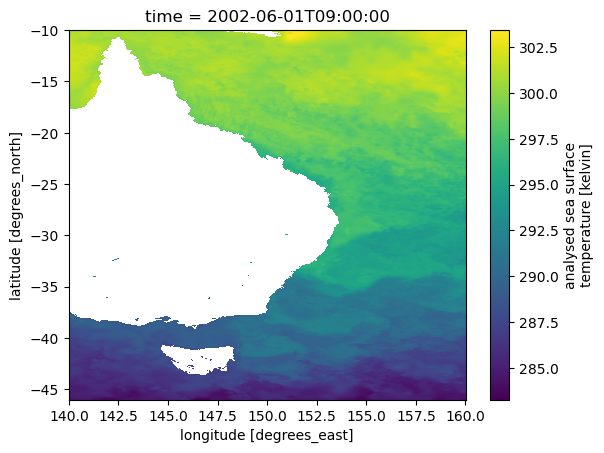

In [8]:
sst.plot()

In [4]:
# aggr_url = "https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc"
aggr_url = "https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/OISST_UHR_NRT-GOS-L4-BLK-v2.0.nc"
data = xr.open_dataset(aggr_url)

Note:Caching=1
Error:curl error: Couldn't connect to server
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: b'https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/OISST_UHR_NRT-GOS-L4-BLK-v2.0.nc'

In [5]:
# importing data from opendap
dap_url="https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"
data = xr.open_dataset(dap_url)#, engine='pydap')

Note:Caching=1
Error:curl error: Couldn't connect to server
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: b'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [4]:
%%time
from xarray.backends import NetCDF4DataStore
 
# Running either of these commands will open the file successfully
aggr_url = "https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc"

ghrsst_url = "https://dapds00.nci.org.au/thredds/catalogs/qm43/ghrsst/ghrsst.html"
 
url_with_fillmismatch = f'{aggr_url}#fillmismatch'
ds = xr.open_dataset(url_with_fillmismatch,drop_variables=['sea_ice_fraction'])
 
ds_subset = ds.sel(lat=slice(-35,0), lon=slice(-180,-180+60))


Error:curl error: Couldn't connect to server
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: b'https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc#fillmismatch'

In [2]:
# directory setup
exp_name = '4xdata3/'
parentdir = '/g/data/v45/jr5971/mhw-analysis/mhw-scaling-tests/'
workdir = parentdir + exp_name

for i in [parentdir, workdir]:
    try: os.mkdir(workdir)
    except: pass

## Import SST Data

In [3]:
import glob

If we want from output 127

In [4]:
ds_list = glob.glob('/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output*/ocean/ocean-2d-surface_temp-1-daily-mean-ym_*.nc')
ds_list[:5]

['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output227/ocean/ocean-2d-surface_temp-1-daily-mean-ym_2014_10.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output029/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1965_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output153/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1996_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output124/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1989_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output023/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1963_10.nc']

In [5]:
len(ds_list)

244

In [6]:
ds_list.sort()
ds_list[:5]

['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1958_01.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output001/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1958_04.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output002/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1958_07.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output003/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1958_10.nc',
 '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output004/ocean/ocean-2d-surface_temp-1-daily-mean-ym_1959_01.nc']

In [7]:
newlist = []
i = 0
while 'ym_1990_' not in ds_list[i]:
    i+=1
first = i
first

128

In [8]:
newlist = ds_list[first:]
len(newlist)

116

In [11]:
ds = xr.open_mfdataset(newlist)

In [12]:
sst = ds['surface_temp']
idx_reg = {'W':-217, 'E':-184, 'S':-48, 'N':-10}
sst = sst.sel(yt_ocean=slice(idx_reg['S'], idx_reg['N']), xt_ocean=slice(idx_reg['W'], idx_reg['E']))
sst = sst.isel(yt_ocean=slice(273,413))

In [13]:
sst

<xarray.DataArray 'surface_temp' (time: 10592, yt_ocean: 140, xt_ocean: 330)>
dask.array<getitem, shape=(10592, 140, 330), dtype=float32, chunksize=(92, 140, 330), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -184.2 -184.1 -184.0
  * yt_ocean  (yt_ocean) float64 -26.55 -26.46 -26.37 ... -13.72 -13.62 -13.52
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2018-12-31T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_conservative_temperature

In [14]:
sst.nbytes/1e6

1957.4016

In [16]:
ny_blocks = 35; y_chunks = len(sst.yt_ocean) // ny_blocks
nx_blocks = 1; x_chunks = len(sst.xt_ocean) // nx_blocks
print(f'xchunks are {x_chunks}, y_chunks are {y_chunks}')

xchunks are 330, y_chunks are 4


In [17]:
lat_S = int(sst.yt_ocean.min().values)
lat_N = int(sst.yt_ocean.max().values)
print(f'lat_S is {lat_S}, lat_N is {lat_N}')

lat_S is -26, lat_N is -13


In [18]:
sst = sst.chunk({'time':-1,'xt_ocean':x_chunks,'yt_ocean':y_chunks})
sst = sst - 273.15
sst

<xarray.DataArray 'surface_temp' (time: 10592, yt_ocean: 140, xt_ocean: 330)>
dask.array<sub, shape=(10592, 140, 330), dtype=float32, chunksize=(10592, 4, 330), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -184.2 -184.1 -184.0
  * yt_ocean  (yt_ocean) float64 -26.55 -26.46 -26.37 ... -13.72 -13.62 -13.52
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2018-12-31T12:00:00

In [31]:
sst

<xarray.DataArray 'surface_temp' (time: 10592, yt_ocean: 140, xt_ocean: 330)>
dask.array<sub, shape=(10592, 140, 330), dtype=float32, chunksize=(10592, 4, 330), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -184.2 -184.1 -184.0
  * yt_ocean  (yt_ocean) float64 -26.55 -26.46 -26.37 ... -13.72 -13.62 -13.52
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2018-12-31T12:00:00

In [ ]:
%%time
sst.to_netcdf('/g/data/v45/jr5971/mhw-analysis/sst_tas.nc')

In [23]:
_, yt, xt = sst.chunks
xtstep = xt[0]
ytstep = yt[0]
xtblocks = len(xt)
ytblocks = len(yt)

# Running MHW code on small subset

In [24]:
from xmhw.xmhw import threshold, detect

Load in the data first to save time in the loop

In [28]:
ytstep

4

In [29]:
ytblocks

35

In [30]:
%%time
ts = sst.isel(yt_ocean=slice(0, ytstep)).load()

KeyboardInterrupt: 

In [27]:
%%time
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []

for j in range (ytblocks):
    yt_from = j*ytstep
    yt_to = (j+1)*ytstep
    ts = sst.isel(yt_ocean=slice(yt_from,yt_to)).load()
    # run function
    results.append(threshold(ts))
    print(f'Chunk {j+1} of size {ts.nbytes/1e6}MB is finished! Time:{str(timedelta(seconds=timer()-start_loop))}')

    # print(f'Chunk {i+j} finished')
    del ts
    j+=1



calendar not in keys


KeyboardInterrupt: 

Right so we've got a successful run of the threshold function above which is a first. Let's make a note of the configuration:
- CPUs: 8 | Load function: before loop | LOAD-TIME: 2min 53s | DATA: chunks=6, shape=(10684,2,165), SIZE: (chunk=13.45MiB) (total=80MiB) | LOOP-TIME: 4min 19s

Now what;
1. Simplest next step - Save this dataset by name, select the next chunk and perform the same process, and repeat for remaining chunks. Very time-consuming. 
2. Run the detect function on this same dataset to understand the timing of this as well. **let's do this**

In [ ]:
results

In [17]:
results_clim = results

In [18]:
%%time
clim = xr.combine_by_coords(results)

CPU times: user 1.34 s, sys: 68.6 ms, total: 1.41 s
Wall time: 1.39 s


In [19]:
%%time
clim.to_netcdf(workdir + 'clim1.nc')

CPU times: user 15min 34s, sys: 41.5 s, total: 16min 15s
Wall time: 25min 7s


In [13]:
clim = xr.open_dataset(workdir + 'clim1.nc')

In [14]:
%%time
thresh = clim['thresh'].load()
seas = clim['seas'].load()

CPU times: user 0 ns, sys: 49.6 ms, total: 49.6 ms
Wall time: 44 ms


In [15]:
%%time
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst1.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        
        th = thresh.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        se = seas.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        j+=1
        # run function
        results.append(detect(ts,th,se))
        del ts, th, se
        print(f'Chunk {i+j} finished')

    i+=1


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set o

Chunk 1 finished


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set o

Chunk 2 finished
Chunk 3 finished
Chunk 4 finished
Chunk 5 finished
Chunk 6 finished
Chunk 7 finished
Chunk 8 finished
Chunk 9 finished


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]


Chunk 10 finished


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set o

Chunk 11 finished
Chunk 12 finished
Chunk 13 finished
Chunk 14 finished
CPU times: user 3min 9s, sys: 17.4 s, total: 3min 26s
Wall time: 7min 2s


Detect Function:
- CPUs: 8 | LOOP-TIME: 26min 20s | Env: analysis3-22-07
* So, I think the reason this took so long previously was because I accidently was performing the threshold function as well
- Function took 33 seconds!!


Update:


In [ ]:
results

In [16]:
for i in range(13):
    results[i].to_netcdf(workdir+f'mhw_result.{i}')

In [18]:
# get lisopen_mfdatasetes to open using open_mfdataset
import glob
mhw_files = glob.glob(workdir+'mhw_result*')
len(mhw_files)

13

In [19]:
mhw = xr.open_mfdataset(mhw_files)

In [20]:
mhw

<xarray.Dataset>
Dimensions:                         (xt_ocean: 330, events: 8851, yt_ocean: 26)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -216.9 -216.8 ... -184.0
  * events                          (events) float64 1.0 2.0 ... 1.068e+04
  * yt_ocean                        (yt_ocean) float64 -47.99 -47.93 ... -46.29
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    index_start                     (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    index_end                       (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    category                        (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    duration                        (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    rate_onset                      (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
    rate_decline                    (events, xt_ocean, yt_ocean) float64 dask.array<chunksize=(8851, 330, 2), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-12: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

Right, so for one sixteenth, the times are:
- clim.nc: 

In [ ]:
%%time
mhw = xr.combine_nested(results, concat_dim=('yt_ocean'))

In [ ]:
%%time
mhw.to_netcdf(workdir+'mhw1.nc')

Right, so if this works, let's setup the bash script that Jules sent.

In [4]:
mhw = xr.open_dataset(workdir+'mhw1.nc')

In [5]:
mhw

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [63]:
intensity_combined = xr.combine_nested(intensity,  concat_dim=(['yt_ocean']))

In [65]:
intensity_combined.shape

(5111, 165, 13)

In [74]:
results[0].dims

Frozen({'xt_ocean': 165, 'yt_ocean': 5, 'events': 3644})

In [75]:
%%time
mhw = xr.combine_nested(results, concat_dim=('yt_ocean'))

CPU times: user 3.63 s, sys: 2.22 s, total: 5.86 s
Wall time: 5.55 s


In [76]:
mhw

<xarray.Dataset>
Dimensions:                         (events: 5111, xt_ocean: 165, yt_ocean: 13)
Coordinates:
  * events                          (events) float64 3.0 5.0 ... 1.064e+04
  * xt_ocean                        (xt_ocean) float64 -200.4 -200.3 ... -184.0
  * yt_ocean                        (yt_ocean) float64 -28.94 -28.85 ... -27.88
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...

Right so update - it looks like the `combine_nested` could work - we just have to make sure that chunks contain all x-cells for an appropriate number of y-cells. 

So, say we start all of this over again, with the full domain. 

In [69]:
results

[<xarray.Dataset>
 Dimensions:                         (xt_ocean: 165, yt_ocean: 5, events: 3644)
 Coordinates:
   * xt_ocean                        (xt_ocean) float64 -200.4 -200.3 ... -184.0
   * yt_ocean                        (yt_ocean) float64 -28.94 -28.85 ... -28.58
   * events                          (events) float64 36.0 37.0 ... 1.064e+04
 Data variables: (12/31)
     event                           (events, xt_ocean, yt_ocean) float64 nan ...
     index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
     index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
     time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
     time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
     time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
     ...                              ...
     intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ..

In [ ]:
mhw = xr.combine_by_coords

In [84]:
test = xr.combine_by_coords(results[:3])

In [85]:
test1 = xr.combine_by_coords(results[-4:])

In [86]:
test1

<xarray.Dataset>
Dimensions:                         (xt_ocean: 64, events: 3238, yt_ocean: 8)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.8 -206.7 ... -200.5
  * events                          (events) float64 133.0 135.0 ... 1.063e+04
  * yt_ocean                        (yt_ocean) float64 -27.53 -27.44 ... -26.9
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

Am i able to save each mhw chunk separately, then try with an old kernel to get the 

In [87]:
%%time
mhw = xr.combine_by_coords(results)

ValueError: Resulting object does not have monotonic global indexes along dimension events

In [78]:
results[1]

<xarray.Dataset>
Dimensions:                         (xt_ocean: 59, yt_ocean: 2, events: 2101)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.3 -206.2 ... -200.5
  * yt_ocean                        (yt_ocean) float64 -28.76 -28.67
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [79]:
for i in range(12):
    n_xt = len(results[i].xt_ocean)
    print(f'results[{i}] has {n_xt} longitudinal cells')

results[0] has 60 longitudinal cells
results[1] has 59 longitudinal cells
results[2] has 59 longitudinal cells
results[3] has 59 longitudinal cells
results[4] has 60 longitudinal cells
results[5] has 61 longitudinal cells
results[6] has 61 longitudinal cells
results[7] has 61 longitudinal cells
results[8] has 60 longitudinal cells
results[9] has 62 longitudinal cells
results[10] has 62 longitudinal cells
results[11] has 64 longitudinal cells


So, there is something else happening as to why we can't combine these results;

In [52]:
res3 = results[3]
res4 = results[4]
res0 = results[0]

In [56]:
res0.events

<xarray.DataArray 'events' (events: 2104)>
array([  134.,   135.,   136., ..., 10625., 10626., 10627.])
Coordinates:
  * events   (events) float64 134.0 135.0 136.0 ... 1.063e+04 1.063e+04

In [61]:
for i in range(6):
    n_events = len(results[i].events)
    print(f'results[{i}] has {n_events} events')

results[0] has 2104 events
results[1] has 2101 events
results[2] has 2093 events
results[3] has 2003 events
results[4] has 2034 events
results[5] has 2074 events


So what is it about results[3] and results[4] that make them not compatible with the rest of the field? 
- Should we just try all of this again on a bigger dataset and see how it goes?

In [59]:
res3.events

<xarray.DataArray 'events' (events: 2003)>
array([  135.,   136.,   137., ..., 10625., 10626., 10627.])
Coordinates:
  * events   (events) float64 135.0 136.0 137.0 ... 1.063e+04 1.063e+04

(array([ 187.,  907., 1495., 1645., 1251.,  957.,  583.,  168.,  162.,
          24.]),
 array([0.50884247, 0.7668234 , 1.0248044 , 1.2827852 , 1.5407661 ,
        1.7987471 , 2.056728  , 2.314709  , 2.5726898 , 2.8306708 ,
        3.0886517 ], dtype=float32),
 <BarContainer object of 10 artists>)

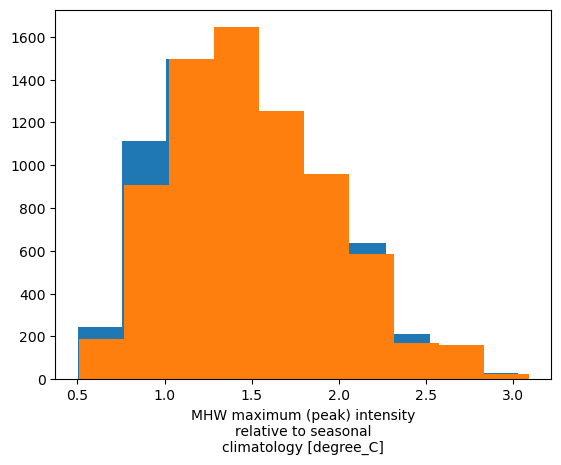

In [55]:
res3['intensity_max'].plot()
res0['intensity_max'].plot()

In [51]:
test2 = xr.combine_by_coords(results[3:5])

ValueError: Resulting object does not have monotonic global indexes along dimension events

In [48]:
test3 = xr.combine_by_coords([test2,resul])

ValueError: Resulting object does not have monotonic global indexes along dimension events

In [46]:
test1 = xr.combine_by_coords([test,results[5]])
test1

<xarray.Dataset>
Dimensions:                         (xt_ocean: 61, events: 3577, yt_ocean: 8)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.5 -206.4 ... -200.5
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
  * yt_ocean                        (yt_ocean) float64 -28.94 -28.85 ... -27.97
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [43]:
test = xr.combine_by_coords(results[:3])

In [27]:
test

<xarray.Dataset>
Dimensions:                         (xt_ocean: 60, events: 2601, yt_ocean: 4)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.4 -206.3 ... -200.5
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
  * yt_ocean                        (yt_ocean) float64 -28.94 -28.85 ... -28.67
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [30]:
test1 = xr.combine_by_coords(results[:3])

In [36]:
test1

<xarray.Dataset>
Dimensions:                         (xt_ocean: 60, events: 2980, yt_ocean: 6)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.4 -206.3 ... -200.5
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
  * yt_ocean                        (yt_ocean) float64 -28.94 -28.85 ... -28.5
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [37]:
results[3]

<xarray.Dataset>
Dimensions:                         (xt_ocean: 59, yt_ocean: 2, events: 2003)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.3 -206.2 ... -200.5
  * yt_ocean                        (yt_ocean) float64 -28.41 -28.32
  * events                          (events) float64 135.0 136.0 ... 1.063e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 135....
    index_start                     (events, xt_ocean, yt_ocean) float64 135....
    index_end                       (events, xt_ocean, yt_ocean) float64 140....
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 0.11...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 0.10...
    category                        (events, xt_ocean, yt_ocean) float64 1.0 ...
    duration                        (events, xt_ocean, yt_ocean) float64 6.0 ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 0.24...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 0.10...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [38]:
results[4]

<xarray.Dataset>
Dimensions:                         (xt_ocean: 60, yt_ocean: 2, events: 2034)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.4 -206.3 ... -200.5
  * yt_ocean                        (yt_ocean) float64 -28.23 -28.14
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [39]:
results[5]

<xarray.Dataset>
Dimensions:                         (xt_ocean: 61, yt_ocean: 2, events: 2074)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.5 -206.4 ... -200.5
  * yt_ocean                        (yt_ocean) float64 -28.06 -27.97
  * events                          (events) float64 134.0 135.0 ... 1.063e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 nan ...
    index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
    index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 nan ...
    category                        (events, xt_ocean, yt_ocean) float64 nan ...
    duration                        (events, xt_ocean, yt_ocean) float64 nan ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 nan ...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 nan ...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [35]:
test2 = xr.combine_by_coords(results[2:4])

ValueError: Resulting object does not have monotonic global indexes along dimension events

In [33]:
test2

<xarray.Dataset>
Dimensions:                         (xt_ocean: 59, yt_ocean: 2, events: 2003)
Coordinates:
  * xt_ocean                        (xt_ocean) float64 -206.3 -206.2 ... -200.5
  * yt_ocean                        (yt_ocean) float64 -28.41 -28.32
  * events                          (events) float64 135.0 136.0 ... 1.063e+04
Data variables: (12/31)
    event                           (events, xt_ocean, yt_ocean) float64 135....
    index_start                     (events, xt_ocean, yt_ocean) float64 135....
    index_end                       (events, xt_ocean, yt_ocean) float64 140....
    time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
    time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
    ...                              ...
    intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 0.11...
    intensity_var_abs               (events, xt_ocean, yt_ocean) float32 0.10...
    category                        (events, xt_ocean, yt_ocean) float64 1.0 ...
    duration                        (events, xt_ocean, yt_ocean) float64 6.0 ...
    rate_onset                      (events, xt_ocean, yt_ocean) float64 0.24...
    rate_decline                    (events, xt_ocean, yt_ocean) float64 0.10...
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Marine heatwave events identified applying the Hobday e...
    history:          2023-01-11: calculated using xmhw code https://github.c...
    xmhw_parameters:  MHW detected using: 5 days of minimum duration;\n      ...

In [20]:
results

[<xarray.Dataset>
 Dimensions:                         (xt_ocean: 60, yt_ocean: 2, events: 2104)
 Coordinates:
   * xt_ocean                        (xt_ocean) float64 -206.4 -206.3 ... -200.5
   * yt_ocean                        (yt_ocean) float64 -28.94 -28.85
   * events                          (events) float64 134.0 135.0 ... 1.063e+04
 Data variables: (12/31)
     event                           (events, xt_ocean, yt_ocean) float64 nan ...
     index_start                     (events, xt_ocean, yt_ocean) float64 nan ...
     index_end                       (events, xt_ocean, yt_ocean) float64 nan ...
     time_start                      (events, xt_ocean, yt_ocean) datetime64[ns] ...
     time_end                        (events, xt_ocean, yt_ocean) datetime64[ns] ...
     time_peak                       (events, xt_ocean, yt_ocean) datetime64[ns] ...
     ...                              ...
     intensity_var_relThresh         (events, xt_ocean, yt_ocean) float64 nan ...
     int

In [21]:
%%time
mhw = xr.combine_by_coords(results)

ValueError: Resulting object does not have monotonic global indexes along dimension events

In [22]:
%%time
mhw = xr.combine_by_coords(results[1:])
mhw.to_netcdf(workdir+'mhw.nc')

CPU times: user 1.25 ms, sys: 1.48 ms, total: 2.74 ms
Wall time: 5.55 ms


In [12]:
mhw = xr.open_dataset(workdir+'mhw.nc')
mhw

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [18]:
mhw

NameError: name 'mhw' is not defined

In [11]:
%%time
# sopen_datasetture work
quad1_sst.to_netcdf(workdir + 'quad1_sst.nc')

In [6]:
# sst_tas = xr.open_dataarray(workdir + 'sst_tas.nc')
quad1_sst = xr.open_dataarray(workdir + 'quad1_sst.nc')

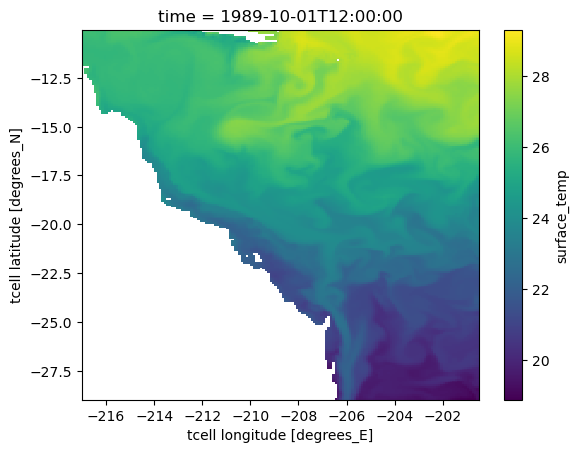

In [7]:
quad1_sst[0,:].plot()

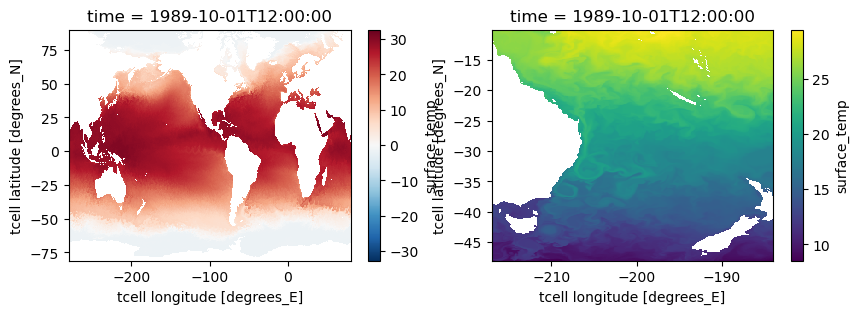

In [11]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); sst[0,:].plot()
plt.subplot(1,2,2); sst_tas[0,:].plot()

In [8]:
quad1_sst

<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 202, xt_ocean: 165)>
[356097720 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -200.7 -200.6 -200.5
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -10.29 -10.2 -10.1
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

# Splitting large datasets for discretised analyses
Both the threshold and detect functions are setup to use dask delayed automatically. I found this was a good way to make sure the main processes would be automatically run in parallel even if you are not experienced with dask. This approach adds some overhead before the actual calculation starts, when dask is working out the task graph. This is usually negligible, but with a bigger grid size you might end up with too many tasks and a less efficient graph. In that case, and anytime you are working with limited resources, it is more efficient to split the grid and run the code separately for each grid section. You can easily recompose the original grid by concatenating together the resulting datasets. 

Below is an example of running `detect` on a big grid by splitting the grid according to chunks. You can split the grid in different ways and the advantage of this method is that the data will be all in one chunk. So by managing the chunksize you can optimise the amount of memory used. Whichever way you are splitting the grid, make sure that it's somehow aligned with the dataset chunks. 

In [9]:
# sst = xr.open_dataarray(workdir+'quad1_sst.nc')
sst = quad1_sst
# split the dataset in half again (so we're working with 8ths)
sst_sub1 = sst.isel(yt_ocean=slice(0, len(sst.yt_ocean)//2))
sst_sub2 = sst.isel(yt_ocean=slice(len(sst.yt_ocean)//2, len(sst.xt_ocean)))
sst_sub2
                    
                    


<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 64, xt_ocean: 165)>
[112823040 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -200.7 -200.6 -200.5
  * yt_ocean  (yt_ocean) float64 -19.75 -19.65 -19.56 ... -13.91 -13.81 -13.72
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

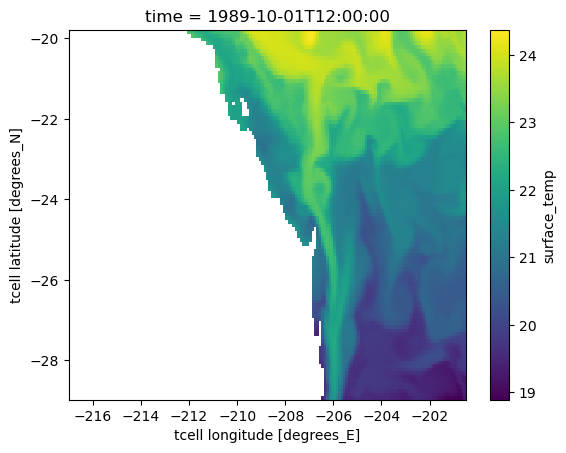

In [15]:
sst_sub1[0,:].plot()

In [22]:
# Chunk
sst = sst_sub1.chunk({'time':-1, 'xt_ocean':-1, 'yt_ocean':10})
dummy, yt, xt = sst.chunks
xtstep = xt[0]
ytstep = yt[0]
xtblocks = len(xt)
ytblocks = len(yt)
print(xtstep, ytstep, xtblocks, ytblocks)

165 10 1 11


In [23]:
sst

<xarray.DataArray 'surface_temp' (time: 10684, yt_ocean: 101, xt_ocean: 165)>
dask.array<xarray-<this-array>, shape=(10684, 101, 165), dtype=float32, chunksize=(10684, 10, 165), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -216.9 -216.8 -216.7 ... -200.7 -200.6 -200.5
  * yt_ocean  (yt_ocean) float64 -28.94 -28.85 -28.76 ... -20.03 -19.94 -19.84
  * time      (time) datetime64[ns] 1989-10-01T12:00:00 ... 2018-12-31T12:00:00

In [25]:
%%time
sst = sst.load()

CPU times: user 1.21 s, sys: 1.22 s, total: 2.43 s
Wall time: 3.33 s


In [29]:
j

11

In [26]:
%%time
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        j+=1
        # run function
        results.append(threshold(ts))
        print(f'Chunk {i+j+1} finished')
        del ts
    i+=1
    


calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys
finished the 1th chunk
calendar not in keys


ValueError: PandasMultiIndex only accepts 1-dimensional variables

In [31]:
%%time
clim = xr.combine_by_coords(results)

CPU times: user 1.98 s, sys: 291 ms, total: 2.27 s
Wall time: 2.24 s


In [32]:
%%time
clim.to_netcdf(workdir + 'clim.nc')

CPU times: user 11min 55s, sys: 40.7 s, total: 12min 36s
Wall time: 13min 44s


If the above fails, let's make the chunk sizes smaller, and try again. If that fails, then we'll further subset - say divide by eighths instead of fourths. 

Update on run of one quadrant - been going for a little whilse (~10 mins) - on the 6th chunk of 17. Memory at 17GiB. 
- been another say 5-10 mins - on the 8th chunk. Memory at 19GiB
- been another 10 mins - on 10th chunk. Mem at 22GiB
- been another 10 mins (about) - on the 13th chunk. Mem has dropped to 17GiB!!! Scratch that - just checked again and it's up to 28GiB - bordering on the limit!

Update on run of one eight; Memory staying low after a few minutes, onto the 3rd of 11 chunks of size 67MiB.

So, it looks like the above code could work however this first attempt seemed to finish the first loop, then on the second, it ran out of memory - perhaps we could save each one individually? 
Or, we try with a smaller test dataset with less overall chunks. So the steps are:
1. Open sst data array, rechunk and load the data
2. Potentially partition this data (total domain failed initially so this is recommended).
3. Run the above code on the subsetted data to obtain a the seas/thresh data.
4. Setup new loop to run the detect function (with intermediate as TRUE!!!! so we can use the blockAverage function after that)

This is what I'll work on when I next have the chance. 

In [ ]:
%%time
mhw = xr.combine_by_coords(results)
mhw.to_netcdf(workdir+'mhw.nc')

In [ ]:
# create an empty list to store the results
# loop first across the ytblocks and then xtblocks
# using xtstep and ytstep to determine the indexes to use with isel

results = []
for i in range(xtblocks):
    xt_from = i*xtstep
    xt_to = (i+1)*xtstep
    for j in range (ytblocks):
        yt_from = j*ytstep
        yt_to = (j+1)*ytstep
        ts = sst.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        results.append(threshold(ts))
        
        th = thresh.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        se = seas.isel(xt_ocean=slice(xt_from,xt_to), yt_ocean=slice(yt_from,yt_to))
        j+=1
        # run function
        results.append(detect(ts,th,se))
        del ts, th, se
    i+=1


The above assumes we have already executed the `threshold` function across the domain, but this could also be implemented in the same fashion - identify roughly the optimum chunk size, where it seemed that the threshold function was the bottleneck, then just do the same to get the larger domain. 

In [8]:
# retrieve chunks information
# xt/yt will be lists - the number of lat/lon points for each chunk
# e.g. [20, 20, 20], [30, 30, 30]
# means we have 20 lat and 30 lon points for each chunk for a total
# of 600 grid cells
# We set these as our "steps"
sst_test = xr.open_dataarray(workdir+'sst_tas.nc')
dummy, xt, yt = sst_test.chunks
xt_step = xt[0]
yt_step = yt[0]
# the length of the list gives the number of chunks
xtblocks = len(xt)
ytblocks = len(yt)
print(xt_step, yt_step, xtblocks, ytblocks)


TypeError: cannot unpack non-iterable NoneType object